In [1]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
# import packages
import pandas as pd
from political_ads.Preprocessor import *
from political_ads.helper import *

In [2]:
#Code to read from our full dataset:
preprocess = Preprocessor()
df = preprocess.file_to_df('/home/gustavgyrst/Desktop/Research Project/political-ad-api/data/all_politicians_aggregated.txt')
df.head(3)

,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
0,2019-05-20,CONFIRMATION NEEDED: Do you want to save Socia...,149.5,3499.5,"[{'percentage': '0.002362', 'region': 'Mississ...","[{'percentage': '0.000476', 'age': '35-44', 'g...",283932788322459,Pete Aguilar for Congress,Pete Aguilar for Congress,186686335555403,100,199,3000,3999
1,2019-05-20,CALLING ALL DEMOCRATS! Congressman Pete Aguila...,49.5,499.5,"[{'percentage': '0.008929', 'region': 'Marylan...","[{'percentage': '0.008929', 'age': '25-34', 'g...",283932788322459,Pete Aguilar for Congress,Pete Aguilar for Congress,291841175036406,0,99,0,999
2,2019-05-20,CALLING ALL DEMOCRATS! Congressman Pete Aguila...,49.5,499.5,"[{'percentage': '0.009346', 'region': 'New Mex...","[{'percentage': '0.476636', 'age': '65+', 'gen...",283932788322459,Pete Aguilar for Congress,Pete Aguilar for Congress,297843221168257,0,99,0,999


In [ ]:
#General stats
print("There are", len(df[df.impressions_lo == 1000000]), "ads with spending of $1,000,000 or above in the data-set")
print(len(df), "ads in total")
print("There are", len(df.dropna(subset=['demographic_distribution'])), "ads after dropping the nan values in the demographic data")


There are 605 ads with spending of $1,000,000 or above in the data-set
602663 ads in total
There are 458635 ads after drop na


In [4]:
df['demographic_distribution'][0]

[{'percentage': '0.000476', 'age': '35-44', 'gender': 'unknown'},
 {'percentage': '0.000476', 'age': '18-24', 'gender': 'male'},
 {'percentage': '0.001427', 'age': '25-34', 'gender': 'female'},
 {'percentage': '0.007612', 'age': '65+', 'gender': 'unknown'},
 {'percentage': '0.191246', 'age': '65+', 'gender': 'male'},
 {'percentage': '0.55138', 'age': '65+', 'gender': 'female'},
 {'percentage': '0.139391', 'age': '55-64', 'gender': 'female'},
 {'percentage': '0.065176', 'age': '55-64', 'gender': 'male'},
 {'percentage': '0.000951', 'age': '25-34', 'gender': 'male'},
 {'percentage': '0.016175', 'age': '45-54', 'gender': 'female'},
 {'percentage': '0.004757', 'age': '35-44', 'gender': 'female'},
 {'percentage': '0.011893', 'age': '45-54', 'gender': 'male'},
 {'percentage': '0.000951', 'age': '45-54', 'gender': 'unknown'},
 {'percentage': '0.005233', 'age': '35-44', 'gender': 'male'},
 {'percentage': '0.000951', 'age': '55-64', 'gender': 'unknown'},
 {'percentage': '0.001903', 'age': '18-2

# 1. Demographic Distribution


In [5]:
#lst of failed attempts
lst_of_failed = []
#The list that will be returned
lst  = []

#Get age distribution
def get_age_distribution(row, gender):
    #The list that will be returned
    lst  = []

    #The map of age_dist
    age_dist = {'13-17': 0.0, '18-24': 0.0, '25-34':0.0, '35-44':0.0, '45-54':0.0, '55-64':0.0, '65+':0.0, 'Unknown': 0.0} #important that Unknown is with capital U
    
    for item in row.demographic_distribution:
        
            try:
                if item['gender'] == gender:
                    age = item['age']
                    percentage = float(item['percentage'])
                    age_dist[age] = age_dist.get(age) + percentage
                else: 
                    pass
            except:
                lst_of_failed.append(row[['page_name', 'demographic_distribution']])
                pass  
    
    for key, value in age_dist.items():
        lst.append(value*row['impressions_hi']) # CHANGED SOMETHING HERE NOT TESTED

    return pd.Series(lst)

In [92]:
NaNs = df[df['demographic_distribution'].isna() == True]
print("Amount of NaNs values in the demographic_distribution field:", len(NaNs))
NaNs.head(1)

print(len(NaNs) / len(df))

Amount of NaNs values in the demographic_distribution field: 139144
0.2308819356754936


In [86]:
demographics = df[['page_name', 'demographic_distribution', 'impressions_hi']].reset_index().drop(columns='index')
print(len(demographics))
demographics = demographics.dropna()
print("Are there nans?:", demographics.isna().any())

#Creating the Columns
age_dist_lst = ['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']
for i in age_dist_lst:
     demographics[i] = 0.0

print(len(demographics))

demographics.head(1)

602663
Are there nans?: page_name                   False
demographic_distribution    False
impressions_hi              False
dtype: bool
463519


,page_name,demographic_distribution,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,Pete Aguilar for Congress,"[{'percentage': '0.000476', 'age': '35-44', 'g...",3999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
demographics_male = demographics.copy()
demographics_female = demographics.copy()
demographics_unknown = demographics.copy()

In [88]:
#Running for male
demographics_male[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row=x, gender='male'), axis=1)

In [89]:
#Running for male
demographics_female[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row = x, gender='female'), axis=1)

In [90]:
demographics_unknown[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row = x, gender='unknown'), axis=1)

In [93]:
demographics_male['gender'] = 'male'
demographics_female['gender'] = 'female'
demographics_unknown['gender'] = 'unknown'

In [94]:
demographics_male

,page_name,demographic_distribution,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown,gender
0,Pete Aguilar for Congress,"[{'percentage': '0.000476', 'age': '35-44', 'g...",3999,0.0,1.903524,3.803049,20.926767,47.560107,260.638824,764.792754,0.0,male
1,Pete Aguilar for Congress,"[{'percentage': '0.008929', 'age': '25-34', 'g...",999,0.0,0.000000,35.678286,8.920071,26.759214,71.357571,142.714143,0.0,male
2,Pete Aguilar for Congress,"[{'percentage': '0.476636', 'age': '65+', 'gen...",999,0.0,0.000000,0.000000,18.673308,18.673308,102.701196,205.401393,0.0,male
3,Pete Aguilar for Congress,"[{'percentage': '0.000309', 'age': '18-24', 'g...",19999,0.0,6.179691,23.198840,51.037448,296.945152,1241.917901,1957.982096,0.0,male
4,Pete Aguilar for Congress,"[{'percentage': '0.000145', 'age': '25-34', 'g...",14999,0.0,4.334711,15.193987,13.019132,73.795080,744.520362,2461.485890,0.0,male
...,...,...,...,...,...,...,...,...,...,...,...,...
602658,Betty McCollum for Congress,"[{'percentage': '0.002597', 'age': '18-24', 'g...",999,0.0,83.033883,212.774013,64.870065,18.163818,25.948026,10.379610,0.0,male
602659,Betty McCollum for Congress,"[{'percentage': '0.002079', 'age': '18-24', 'g...",999,0.0,120.461418,220.153626,53.999946,24.923052,12.461526,22.846131,0.0,male
602660,Betty McCollum for Congress,"[{'percentage': '0.001551', 'age': '18-24', 'g...",19999,0.0,4005.999690,4254.107284,1762.631864,656.467175,346.322683,304.964751,0.0,male
602661,Betty McCollum for Congress,"[{'percentage': '0.002569', 'age': '18-24', 'g...",19999,0.0,4268.826548,3558.902046,1410.489472,537.113143,298.905054,359.622018,0.0,male


In [95]:
demographics_female

,page_name,demographic_distribution,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown,gender
0,Pete Aguilar for Congress,"[{'percentage': '0.000476', 'age': '35-44', 'g...",3999,0.0,7.610097,5.706573,19.023243,64.683825,557.424609,2204.968620,0.0,female
1,Pete Aguilar for Congress,"[{'percentage': '0.008929', 'age': '25-34', 'g...",999,0.0,0.000000,8.920071,8.920071,44.598357,196.232571,445.982571,0.0,female
2,Pete Aguilar for Congress,"[{'percentage': '0.476636', 'age': '65+', 'gen...",999,0.0,18.673308,0.000000,0.000000,0.000000,158.720121,476.159364,0.0,female
3,Pete Aguilar for Congress,"[{'percentage': '0.000309', 'age': '18-24', 'g...",19999,0.0,27.838608,75.776211,105.174741,748.542571,4636.688154,10742.642841,0.0,female
4,Pete Aguilar for Congress,"[{'percentage': '0.000145', 'age': '25-34', 'g...",14999,0.0,13.019132,21.703553,45.581961,138.920738,2187.994124,9179.567988,0.0,female
...,...,...,...,...,...,...,...,...,...,...,...,...
602658,Betty McCollum for Congress,"[{'percentage': '0.002597', 'age': '18-24', 'g...",999,0.0,145.309545,293.212494,77.844078,15.568416,15.568416,25.948026,0.0,female
602659,Betty McCollum for Congress,"[{'percentage': '0.002079', 'age': '18-24', 'g...",999,0.0,116.307576,274.153572,53.999946,20.769210,26.999973,45.692262,0.0,female
602660,Betty McCollum for Congress,"[{'percentage': '0.001551', 'age': '18-24', 'g...",19999,0.0,3111.764404,3127.263629,1338.773058,465.216738,284.305784,222.268886,0.0,female
602661,Betty McCollum for Congress,"[{'percentage': '0.002569', 'age': '18-24', 'g...",19999,0.0,5249.617506,2437.998094,817.339131,308.244587,284.905754,312.924353,0.0,female


In [96]:
demographics_unknown

,page_name,demographic_distribution,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown,gender
0,Pete Aguilar for Congress,"[{'percentage': '0.000476', 'age': '35-44', 'g...",3999,0.0,0.000000,0.000000,1.903524,3.803049,3.803049,30.440388,0.0,unknown
1,Pete Aguilar for Congress,"[{'percentage': '0.008929', 'age': '25-34', 'g...",999,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8.920071,0.0,unknown
2,Pete Aguilar for Congress,"[{'percentage': '0.476636', 'age': '65+', 'gen...",999,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,unknown
3,Pete Aguilar for Congress,"[{'percentage': '0.000309', 'age': '18-24', 'g...",19999,0.0,0.000000,0.000000,1.539923,7.739613,23.198840,52.577371,0.0,unknown
4,Pete Aguilar for Congress,"[{'percentage': '0.000145', 'age': '25-34', 'g...",14999,0.0,0.000000,2.174855,2.174855,2.174855,23.878408,69.460369,0.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
602658,Betty McCollum for Congress,"[{'percentage': '0.002597', 'age': '18-24', 'g...",999,0.0,2.594403,5.189805,2.594403,0.000000,0.000000,0.000000,0.0,unknown
602659,Betty McCollum for Congress,"[{'percentage': '0.002079', 'age': '18-24', 'g...",999,0.0,2.076921,0.000000,2.076921,0.000000,0.000000,2.076921,0.0,unknown
602660,Betty McCollum for Congress,"[{'percentage': '0.001551', 'age': '18-24', 'g...",19999,0.0,31.018449,46.517674,10.339483,5.159742,15.499225,10.339483,0.0,unknown
602661,Betty McCollum for Congress,"[{'percentage': '0.002569', 'age': '18-24', 'g...",19999,0.0,51.377431,56.037198,18.679066,14.019299,4.679766,9.339533,0.0,unknown


In [106]:
demographics_male_g = demographics_male.groupby('page_name').sum()
demographics_female_g = demographics_female.groupby('page_name').sum()
demographics_unknown_g = demographics_unknown.groupby('page_name').sum()



demographics_male_g['gender'] = 'male'
demographics_female_g['gender'] = 'female'
demographics_unknown_g['gender'] = 'unknown'


In [107]:
frames = [demographics_female_g,demographics_male_g,demographics_unknown_g]
total = pd.concat(frames)


In [108]:
test = total.groupby('gender').sum()

In [109]:
test.reset_index(inplace=True)
test

,gender,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,female,8100707086,600077.609906,3.754320e+08,7.577947e+08,6.712412e+08,6.612127e+08,8.620431e+08,1.126484e+09,0.000000
1,male,8100707086,345769.075192,2.825665e+08,6.985221e+08,5.968778e+08,5.895645e+08,6.670182e+08,7.201480e+08,0.000000
2,unknown,8100707086,25879.089309,9.007808e+06,2.047281e+07,1.570489e+07,1.191293e+07,1.463895e+07,1.900287e+07,4172.075045


In [110]:
test.set_index('gender', inplace=True)


In [111]:
test.drop(columns='impressions_hi', inplace=True)

<AxesSubplot:>

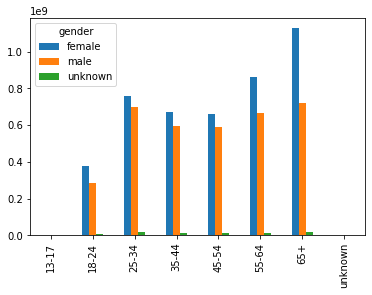

In [112]:
test.T.plot(kind='bar')

In [113]:

from matplotlib import pyplot as plt

In [114]:
demo_view = demographics.groupby('page_name').sum()
#demo_view = demo_view.drop(columns='demographic_distribution')
demo_view = demo_view.drop(columns='impressions_hi')


demo_view

,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
page_name,,,,,,,,
A. Donald McEachin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abigail Spanberger,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adam Kinzinger,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adam Schiff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adam Smith for Congress,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
Yarmuth for Congress,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Young Kim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yvette D. Clarke,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


559

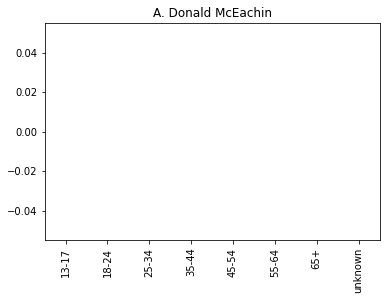

In [115]:
demo_view.iloc[0].plot(kind='bar', y='Impressions', x='age', title=demo_view.index[0])

len(demo_view)
#https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot


In [116]:

congress = pd.read_csv("/home/gustavgyrst/Desktop/Research Project/political-ad-api/src/data_sets/legislators_fb_info_final.csv")
congress

,Unnamed: 0,Unnamed: 0.1,first_name,last_name,full_name,type,state,district,party,facebook,page_name,identifier,page_id
0,0,0,Sherrod,Brown,Sherrod Brown,sen,OH,NaN,Democrat,SenatorSherrodBrown,NaN,0,6266829799
1,1,1,Maria,Cantwell,Maria Cantwell,sen,WA,NaN,Democrat,senatorcantwell,Senator Maria Cantwell,100044609161538,9351652533
2,2,2,Benjamin,Cardin,Benjamin L. Cardin,sen,MD,NaN,Democrat,senatorbencardin,Senator Ben Cardin,100044326544838,no match
3,3,3,Thomas,Carper,Thomas R. Carper,sen,DE,NaN,Democrat,tomcarper,Senator Tom Carper,100044593172202,165571920202215
4,4,4,Robert,Casey,"Robert P. Casey, Jr.",sen,PA,NaN,Democrat,SenatorBobCasey,U.S. Senator Bob Casey,100044143479624,6781166087
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,533,533,Claudia,Tenney,Claudia Tenney,rep,NY,22.0,Republican,NaN,NaN,0,183020072173458
534,534,534,Julia,Letlow,Julia Letlow,rep,LA,5.0,Republican,NaN,NaN,0,101501768597429
535,535,535,Troy,Carter,Troy A. Carter,rep,LA,2.0,Democrat,NaN,NaN,0,876319055750124
536,536,536,Melanie,Stansbury,Melanie A. Stansbury,rep,NM,1.0,Democrat,NaN,NaN,0,128551641258085


In [117]:
#Checking for uknown data:
unknown_age_in_demographics = demographics[demographics['unknown'] != 0.0]
print("There are", len(unknown_age_in_demographics), "values with unknown age group")


There are 0 values with unknown age group


In [118]:
#Analysis by party
party = 'Democrat'

party_members = congress[congress["party"] == party]  # get all page id's that match the given party

demographics_democrats = demographics[demographics.page_name.isin(party_members.page_name)] # get all the ads where page id matches with the party page id's

demographics_democrats['party'] = 'democrat'


/tmp/ipykernel_21987/3447317543.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_democrats['party'] = 'democrat'


/home/gustavgyrst/.local/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:title={'center':'democrats'}>

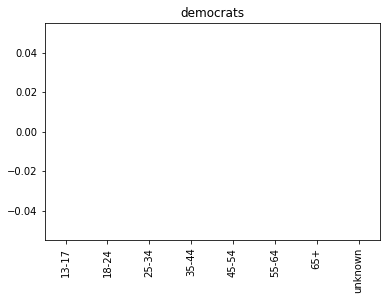

In [119]:
demographics_democrats.drop(columns='impressions_hi', inplace=True)

d_view = demographics_democrats.groupby('party').sum()


d_view.iloc[0].plot(kind='bar', title="democrats")


In [120]:

demographics_republicans.drop(columns='impressions_hi', inplace=True)

r_view = demographics_republicans.groupby('party').sum()

r_view.iloc[0].plot(kind='bar', title="republicans")


NameError: name 'demographics_republicans' is not defined

In [ ]:
party_r = 'Republican'

party_members = congress[congress["party"] == party_r]  # get all page id's that match the given party

demographics_republicans = demographics[demographics.page_name.isin(party_members.page_name)] # get all the ads where page id matches with the party page id's

demographics_republicans['party'] = 'republican'


/tmp/ipykernel_28043/3402324449.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_republicans['party'] = 'republican'


In [ ]:
#The one that didn't make it
lst_of_failed

[page_name                        Elizabeth Warren
 demographic_distribution    [{'percentage': '1'}]
 Name: 491726, dtype: object,
 page_name                        Elizabeth Warren
 demographic_distribution    [{'percentage': '1'}]
 Name: 491727, dtype: object,
 page_name                        Elizabeth Warren
 demographic_distribution    [{'percentage': '1'}]
 Name: 491736, dtype: object,
 page_name                        Elizabeth Warren
 demographic_distribution    [{'percentage': '1'}]
 Name: 491748, dtype: object,
 page_name                        Elizabeth Warren
 demographic_distribution    [{'percentage': '1'}]
 Name: 491770, dtype: object,
 page_name                        Elizabeth Warren
 demographic_distribution    [{'percentage': '1'}]
 Name: 491776, dtype: object]

# Age Distribtuion

In [ ]:
#Random sum check
sum = 0
for i in df.demographic_distribution[0]:
    sum += float(i.get('percentage'))
print("The sum of all the percentages given in the dictionary of diff values (yep they don't sum to 100", sum)
#So... they don't even sum up to a hundred



The sum of all the percentages given in the dictionary of diff values (yep they don't sum to 100 0.9999980000000002


In [ ]:
list_of_failed_g = []
count_unknown =0
def get_gender_distribution(row):
    
    #initializing percentages
    percentage_male = 0.0
    percentage_female = 0.0
    percentage_unknown = 0.0

    try:
        for item in row.demographic_distribution:
            if item['gender'] == 'male':
                percentage_male += float(item['percentage'])
            elif item['gender'] == 'female':
                percentage_female += float(item['percentage'])
            elif item['gender'] == 'unknown':
                percentage_unknown += float(item['percentage'])
                count_unknown+=1
    except:
        list_of_failed_g.append(lst)
    
    avg_imp = float(row['avg_impressions'])
    lst_all_genders = [percentage_male, percentage_female, percentage_unknown]
    for i in range(3):
        lst_all_genders[i] = lst_all_genders[i]*avg_imp
    
    #Getting the avg impression to get the weight of the gender distribution
    return pd.Series(lst_all_genders)


In [ ]:
#Making a Df representing the gender distribution:
gender = df[['page_name','demographic_distribution', 'impressions_lo', 'impressions_hi']]

#Dropping NaNs
gender = gender.dropna()
gender['avg_impressions'] = gender.apply(lambda x: ((x['impressions_lo'] + x['impressions_hi']) / 2), axis=1)



In [ ]:
gender.head(1)


,page_name,demographic_distribution,impressions_lo,impressions_hi,avg_impressions,male,female,unknown
0,Pete Aguilar for Congress,"[{'percentage': '0.000476', 'age': '35-44', 'g...",3000,3999,3499.5,962.275012,2502.257983,0.0


In [ ]:
gender[['male', 'female', 'unknown']] = gender.apply(get_gender_distribution, axis=1)


KeyboardInterrupt: 

In [ ]:
gender_cleaned = gender.drop(['impressions_hi', 'impressions_lo', 'demographic_distribution', 'avg_impressions' ], axis=1)
gender_cleaned = gender_cleaned.groupby('page_name').sum()

In [ ]:
gender_cleaned[gender_cleaned.unknown !]

,male,female,unknown
page_name,,,


In [ ]:
index_of_pol = 536

gender_cleaned.iloc[index_of_pol].plot(kind='bar', y='impressions', x='gender', title=demo_view.index[index_of_pol])

len(gender_cleaned)


NameError: name 'demo_view' is not defined

In [ ]:
#Finding -- We have two campaign accounts for vincente gonzales (2020 and 2022)
# on index 536 and 537...

df_all_ad_pages = pd.read_csv('/home/gustavgyrst/Desktop/Research Project/political-ad-api/data/FacebookAdLibraryReport_2021-10-15_US_lifelong_advertisers.csv')
df_all_ad_pages[df_all_ad_pages['Page Name'].str.contains('U.S. Congressman Vicente Gonzalez 2020', na=False)]
#No result....

/home/gustavgyrst/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Page ID,Page Name,Disclaimer,Amount Spent (USD),Number of Ads in Library


# 2. Geographic Distribution

In [ ]:
#https://datascience.stackexchange.com/questions/9616/how-to-create-us-state-choropleth-map
#Convert the demographic data into a heat-map
